In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
ac = np.loadtxt('A5_data/ac.txt')
s = np.loadtxt('A5_data/s.txt')
time = np.loadtxt('A5_data/time.txt')
fs = 1/(time[1]-time[0])

df = pd.DataFrame({'time':time, 's':s, 'ac':ac})

In [3]:
times = df['time'][df['time']<=20]
ss= df['s'][df['time']<=20]
acs= df['ac'][df['time']<=20]

ADD MORE PLOTS HERE

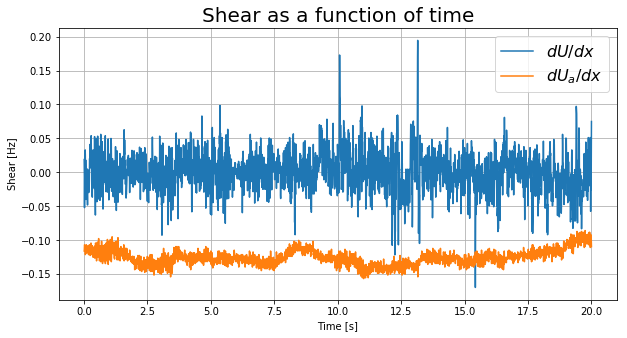

In [4]:
plt.figure(figsize=(10,5))
plt.plot(times, ss, label='$dU/dx$')
plt.plot(times, acs, label='$dU_a/dx$')
plt.legend(fontsize=16)
plt.xlabel('Time [s]')
plt.ylabel('Shear [Hz]')
plt.title('Shear as a function of time', fontsize=20)
plt.grid()

plt.show()

# Question 2

In [5]:
from scipy.signal import welch

Use hanning windows with no overlap. Use a hanning window as the taper. Note that scipy uses zero padding when nperseg is not a multiple of the time series.

In [6]:
ff_s1, spec_s1 = welch(s, fs=fs, nperseg=64, noverlap=0, window='hann') 
ff_s2, spec_s2 = welch(s, fs=fs, nperseg=256, noverlap=0, window='hann') 
ff_s3, spec_s3 = welch(s, fs=fs, nperseg=2560, noverlap=0, window='hann') 
ff_s4, spec_s4 = welch(s, fs=fs, nperseg=24000, noverlap=0, window='hann') 

ff_ac1, spec_ac1 = welch(ac, fs=fs, nperseg=64, noverlap=0, window='hann') 
ff_ac2, spec_ac2 = welch(ac, fs=fs, nperseg=256, noverlap=0, window='hann') 
ff_ac3, spec_ac3 = welch(ac, fs=fs, nperseg=2560, noverlap=0, window='hann') 
ff_ac4, spec_ac4 = welch(ac, fs=fs, nperseg=24000, noverlap=0, window='hann') 

Plot.

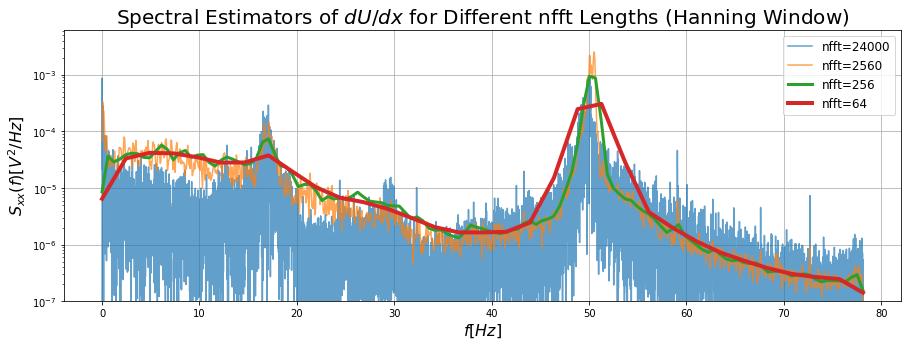

In [7]:
plt.figure(figsize=(15,5))
plt.semilogy(ff_s4, spec_s4, alpha=0.7, label='nfft=24000')
plt.semilogy(ff_s3, spec_s3, alpha=0.7, label='nfft=2560')
plt.semilogy(ff_s2, spec_s2, lw=3, label='nfft=256')
plt.semilogy(ff_s1, spec_s1, lw=4, label='nfft=64')
plt.ylim(bottom=10**(-7))
plt.grid()
plt.legend(fontsize=12)
plt.ylabel(r'$S_{xx}(f)  [V^2/Hz]$', fontsize=16)
plt.xlabel(r'$f [Hz]$', fontsize=16)
plt.title('Spectral Estimators of $dU/dx$ for Different nfft Lengths (Hanning Window)', fontsize=20)
plt.show()

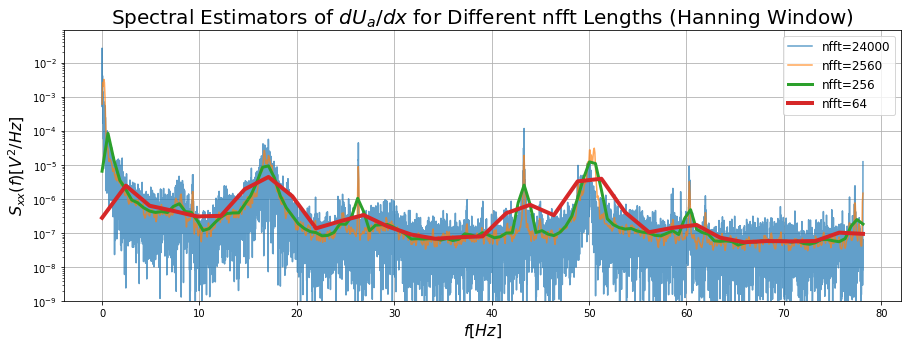

In [8]:
plt.figure(figsize=(15,5))
plt.semilogy(ff_ac4, spec_ac4, alpha=0.7, label='nfft=24000')
plt.semilogy(ff_ac3, spec_ac3, alpha=0.7, label='nfft=2560')
plt.semilogy(ff_ac2, spec_ac2, lw=3, label='nfft=256')
plt.semilogy(ff_ac1, spec_ac1, lw=4, label='nfft=64')
plt.ylim(bottom=10**(-9))
plt.grid()
plt.legend(fontsize=12)
plt.ylabel(r'$S_{xx}(f)  [V^2/Hz]$', fontsize=16)
plt.xlabel(r'$f [Hz]$', fontsize=16)
plt.title('Spectral Estimators of $dU_a/dx$ for Different nfft Lengths (Hanning Window)', fontsize=20)
plt.show()

Lets check to make sure this definition of the spectrum is indeed the definition you gave us: i.e. the integral of the spectrum should yield the variance of $s$ (assuming $s$ has zero mean- which it basically does).

In [9]:
np.var(s)

0.0023982981542625013

Lets check the spectra:

In [10]:
print('Variance from nperseg=64 is {}'.format(sum(spec_s1)*(ff_s1[1]-ff_s1[0])))
print('Variance from nperseg=256 is {}'.format(sum(spec_s2)*(ff_s2[1]-ff_s2[0])))
print('Variance from nperseg=2560 is {}'.format(sum(spec_s3)*(ff_s3[1]-ff_s3[0])))
print('Variance from nperseg=24000 is {}'.format(sum(spec_s4)*(ff_s4[1]-ff_s4[0])))

Variance from nperseg=64 is 0.002235288195736561
Variance from nperseg=256 is 0.0023238626219822117
Variance from nperseg=2560 is 0.002341632036528753
Variance from nperseg=24000 is 0.000531880234607352


Note that the npserseg=24000 spectrum underestimates the variance: this is due to zero-padding used in the scipy procedure. We can do the same test with the ac data set.

In [11]:
np.var(ac-np.mean(ac))

0.0010867773231812284

In [12]:
print('Variance from nperseg=64 is {}'.format(sum(spec_ac1)*(ff_ac1[1]-ff_ac1[0])))
print('Variance from nperseg=256 is {}'.format(sum(spec_ac2)*(ff_ac2[1]-ff_ac2[0])))
print('Variance from nperseg=2560 is {}'.format(sum(spec_ac3)*(ff_ac3[1]-ff_ac3[0])))
print('Variance from nperseg=24000 is {}'.format(sum(spec_ac4)*(ff_ac4[1]-ff_ac4[0])))

Variance from nperseg=64 is 5.6880115092435315e-05
Variance from nperseg=256 is 0.00011820696762923455
Variance from nperseg=2560 is 0.0008263894113412267
Variance from nperseg=24000 is 0.0005559909441211094


There is a pattern here: something that must be explained. Note that we vastly underestimate the variance for nfft=64. This is due to the fact that the spectrum of $dU_a/dx$ has significant energy at low frequencies; when we use a small window with a hanning taper, we lose energy at these low frequencies. The estimate for the variance gets better as we go to 256 and 2560, but then it drops again at 24000. This, again, is due to the zero padding procedure used by scipy.

# Question 3

Here we show the effects of aliasing. Theoretically we know that

$$\hat{S_{x_t}}(f) = \sum_{k=-\infty}^\infty S_{x(t)}(f+k/\Delta t)$$

where $x_t$ is our discretely sampled time series, $x(t)$ is our true continuous process, $\hat{S_{x_t}}$ is the spectral estimator (obtained using $x_t$) of true spectrum  $S_{x(t)}$  and $\Delta t = 1/f$ where $f$ is our sampling frequency. For a normal spectrum, we don't take the sum from $-\infty$ to $\infty$, we might only choose a few intervals of $k$. 

Note that we are dealing with spectral estimators, not the true spectra. Thus the forumla above holds to some approximation.   We show the effects of aliasing in two ways

* We sub sample the time series and plot the spectrum
* We manually "flip in" the spectrum using the formula above. In other words, we take the spectrum for the normally sampled time series, split it up into many intervals, and add the intervals together (flipping some as required, as we are considering a 1-sided PSD).

The functions defined below are used for my second bullet point above.

In [13]:
def split_padded(a,n):
    padding = len(a)//n - len(a)%n
    return np.split(np.concatenate((a,np.zeros(padding))),(n+1))

def fold_in(prdg, scale):
    f = split_padded(prdg, scale)
    N = len(f[0])
    
    ff = np.linspace(0, 1/2, N) *fs/scale
    new_prdg = f[0]
    for (i, arr) in enumerate(f[1:]):
        if i%2 == 1:
            new_prdg += arr
        else:
            new_prdg += np.flip(arr)
    
    
    return ff, new_prdg

Compute the regular spectrum, the spectrum of the sub sampled time series, and the "flipped-in" spectrum.

In [14]:
s_subsamp = s[::10]

ff_s, spec_s = welch(s, fs=fs, nperseg=2560, noverlap=0, window='hann') 
ff_ssub, spec_ssub = welch(s_subsamp, fs=fs/10, nperseg=256, noverlap=0, window='hann') 
ff_ssub_theo, spec_ssub_theo = fold_in(spec_s, 10) 

Plot full spectrum.

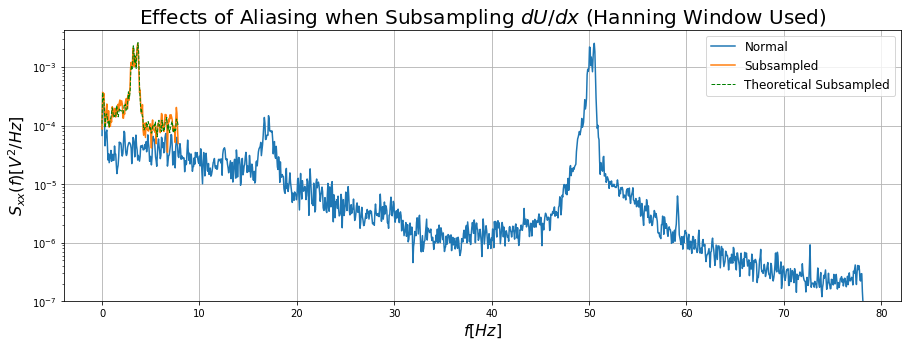

In [36]:
plt.figure(figsize=(15,5))

plt.semilogy(ff_s, spec_s, label='Normal')
plt.semilogy(ff_ssub, spec_ssub,  label='Subsampled')
plt.semilogy(ff_ssub_theo, spec_ssub_theo, label='Theoretical Subsampled', ls='--', lw=1, c='green')

plt.ylim(bottom=10**(-7))
plt.grid()
plt.legend(fontsize=12)
plt.ylabel(r'$S_{xx}(f)  [V^2/Hz]$', fontsize=16)
plt.xlabel(r'$f [Hz]$', fontsize=16)
plt.title('Effects of Aliasing when Subsampling $dU/dx$ (Hanning Window Used)', fontsize=20)
plt.show()

Plot area of interest.

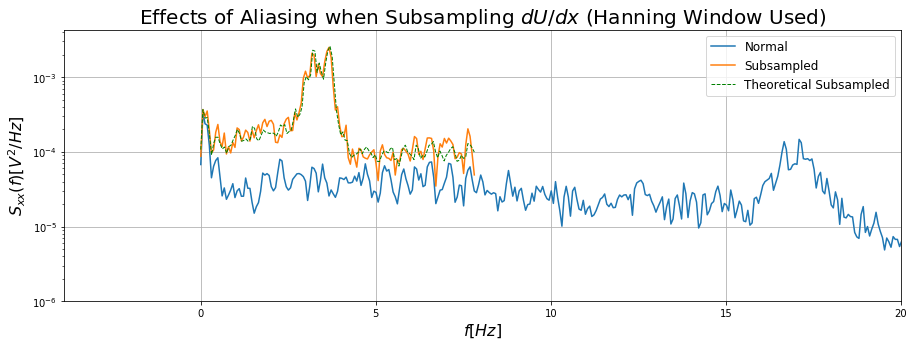

In [34]:
plt.figure(figsize=(15,5))

plt.semilogy(ff_s, spec_s, label='Normal')
plt.semilogy(ff_ssub, spec_ssub,  label='Subsampled')
plt.semilogy(ff_ssub_theo, spec_ssub_theo, label='Theoretical Subsampled', ls='--', lw=1, c='green')

plt.ylim(bottom=10**(-6))
plt.grid()
plt.legend(fontsize=12)
plt.ylabel(r'$S_{xx}(f)  [V^2/Hz]$', fontsize=16)
plt.xlabel(r'$f [Hz]$', fontsize=16)
plt.title('Effects of Aliasing when Subsampling $dU/dx$ (Hanning Window Used)', fontsize=20)
plt.xlim(right=20)
plt.show()

Note that the theoretical subsampled spectrum and subsampled spectrum don't match perfectly. This is because we are looking at *estimators* of the spectrum above, and 

$$\hat{S_{x_t}}(f) = \sum_{k=-\infty}^\infty S_{x(t)}(f+k/\Delta t)$$

only holds for the true spectrum (estimators introduce bias (leakage) and variance in frequency estimates). Note also that we have much more power in lower frequencies in the subsampled spectrum.

Now we compute the variance (as the integral of the spectrum). Note that it should *not* change because we have folded back power into the lower frequency region.

In [16]:
print('Variance from Normal is {}'.format(sum(spec_s)*(ff_s[1]-ff_s[0])))
print('Variance from Sub-sampled is {}'.format(sum(spec_ssub)*(ff_ssub[1]-ff_ssub[0])))
print('Variance from Theoretical Sub-sampled is {}'.format(sum(spec_ssub_theo)*(ff_ssub_theo[1]-ff_ssub_theo[0])))

Variance from Normal is 0.002341632036528753
Variance from Sub-sampled is 0.0023913833111666714
Variance from Theoretical Sub-sampled is 0.0023600700840604783


These should be equal to the variance of $s$ (approximately).

In [17]:
np.var(s)

0.0023982981542625013

and they are indeed!

# Question 4

Use a running mean for smoothing

In [25]:
v = 1/(10) * (np.zeros(10)+1)
s_smooth = np.convolve(s, v, mode='same') # keep time series same length
s_smooth_sub = s_smooth[::10]

ffs_smooth_sub, specs_smooth_sub = welch(s_smooth_sub, fs=fs/10, nperseg=256, noverlap=0, window='hann') 

Plot the signal

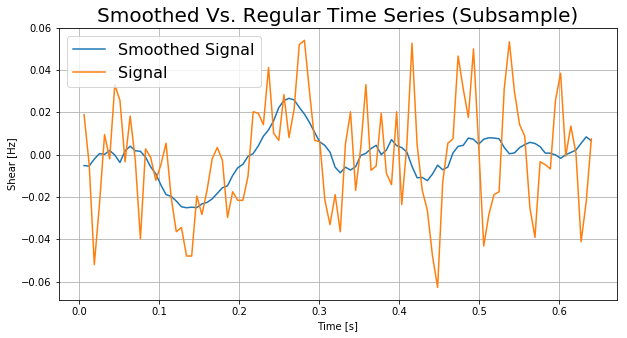

In [44]:
plt.figure(figsize=(10,5))
plt.plot(time[0:100], s_smooth[0:100], label='Smoothed Signal')
plt.plot(time[0:100], s[0:100], label='Signal')
plt.legend(fontsize=16)
plt.xlabel('Time [s]')
plt.ylabel('Shear [Hz]')
plt.title('Smoothed Vs. Regular Time Series (Subsample)', fontsize=20)
plt.grid()

plt.show()

Compare the spectra. Plot full spectrum.

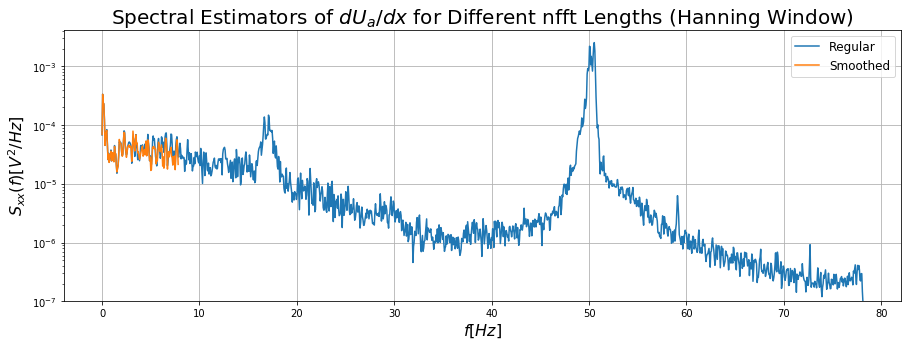

In [37]:
plt.figure(figsize=(15,5))
plt.semilogy(ff_s, spec_s, label='Regular')
plt.semilogy(ffs_smooth_sub, specs_smooth_sub, label='Smoothed')
plt.ylim(bottom=10**(-7))
plt.grid()
plt.legend(fontsize=12)
plt.ylabel(r'$S_{xx}(f)  [V^2/Hz]$', fontsize=16)
plt.xlabel(r'$f [Hz]$', fontsize=16)
plt.title('Spectral Estimators of $dU_a/dx$ for Different nfft Lengths (Hanning Window)', fontsize=20)
plt.show()

Plot area of interest.

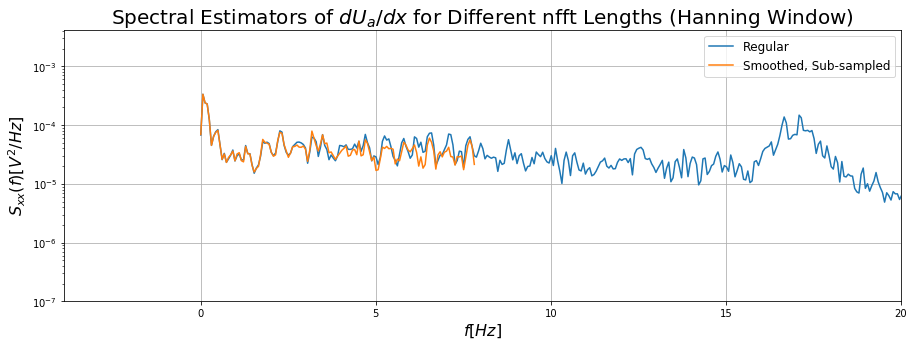

In [42]:
plt.figure(figsize=(15,5))
plt.semilogy(ff_s, spec_s, label='Regular')
plt.semilogy(ffs_smooth_sub, specs_smooth_sub, label='Smoothed, Sub-sampled')
plt.xlim(right=20)
plt.ylim(bottom=10**(-7))
plt.grid()
plt.legend(fontsize=12)
plt.ylabel(r'$S_{xx}(f)  [V^2/Hz]$', fontsize=16)
plt.xlabel(r'$f [Hz]$', fontsize=16)
plt.title('Spectral Estimators of $dU_a/dx$ for Different nfft Lengths (Hanning Window)', fontsize=20)
plt.show()

Unlike question 3, we no longer have more power in lower frequencies in the subsampled spectrum In other words, no "folding back" of the spectrum has occurred, which 

$$\hat{S_{x_t}}(f) = \sum_{k=-\infty}^\infty S_{x(t)}(f+k/\Delta t)$$ 

predicts. Why is this the case? This is due to the fact that the discrete time series $x_t$ has been filtered such that the power in all frequencies above the new nyquist frequency $1/(2 \Delta t_{new}) = 1/(20 \Delta t) = 7.8125 \text{Hz}$ are removed. This is charateristic of the fact that the integral is a low pass filter (the running mean is an effective integral). Thus the smoothed time series loses energy at these higher frequencies, so we should expect a lower variance estimate.

In [43]:
print('Variance of s: {}'.format(np.var(s)))
print('Variance from Normal is {}'.format(sum(spec_s)*(ff_s[1]-ff_s[0])))
print('Variance from Smoothed, Sub-sampled is {}'.format(sum(specs_smooth_sub)*(ffs_smooth_sub[1]- ffs_smooth_sub[0])))

Variance of s: 0.0023982981542625013
Variance from Normal is 0.002341632036528753
Variance from Smoothed, Sub-sampled is 0.00034407847295414963


As expected, the variance estimate of the time series has decreased due to filtering.

# Question 5

Obtain the active and quiet phases of $s$.

In [57]:
times_act = time[(time>=200)&(time<=250)]
s_act = s[(time>=200)&(time<=250)]

times_qui = time[(time>=50)&(time<=100)]
s_qui = s[(time>=50)&(time<=100)]

Plot the differences

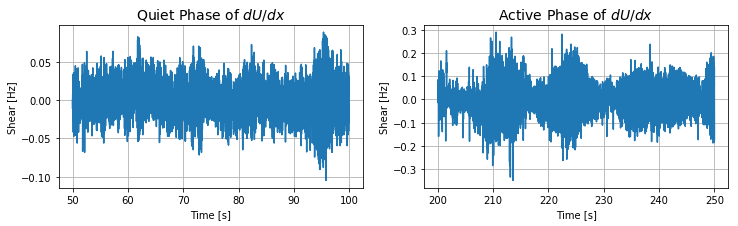

In [68]:
fig, axes = plt.subplots(1,2,figsize=(12,3))

ax = axes[0]
ax.plot(times_qui, s_qui)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Shear [Hz]')
ax.set_title('Quiet Phase of $dU/dx$', fontsize=14)
ax.grid()

ax = axes[1]
ax.plot(times_act, s_act)
ax.set_xlabel('Time [s]')
ax.set_ylabel('Shear [Hz]')
ax.set_title('Active Phase of $dU/dx$', fontsize=14)
ax.grid()

Obtain the spectra.

In [62]:
ff_s_act, spec_s_act = welch(s_act, fs=fs, nperseg=256, noverlap=0, window='hann') 
ff_s_qui, spec_s_qui = welch(s_qui, fs=fs, nperseg=256, noverlap=0, window='hann') 

Plot.

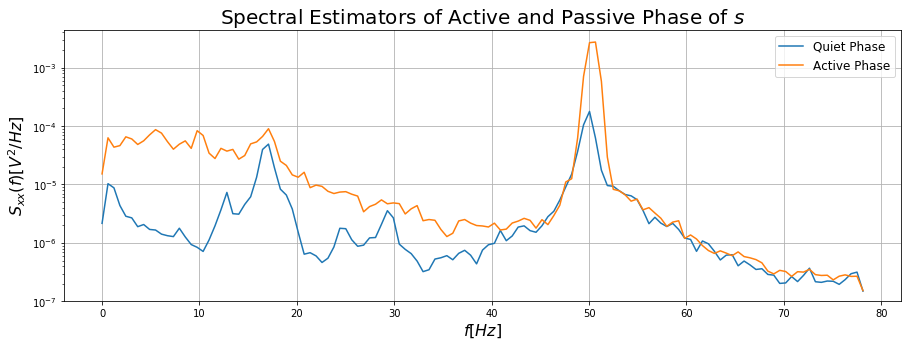

In [74]:
plt.figure(figsize=(15,5))
plt.semilogy(ff_s_qui, spec_s_qui, label='Quiet Phase')
plt.semilogy(ff_s_act, spec_s_act, label='Active Phase')
plt.ylim(bottom=10**(-7))
plt.grid()
plt.legend(fontsize=12)
plt.ylabel(r'$S_{xx}(f)  [V^2/Hz]$', fontsize=16)
plt.xlabel(r'$f [Hz]$', fontsize=16)
plt.title('Spectral Estimators of Active and Passive Phase of $s$', fontsize=20)
plt.show()

The differences are

* **Low Frequency Region**: The active phase appears to have more energy in all lower frequencies up to around 45Hz.
* **Mid Frequency Spike**: The active phase has about 10 times more energy in the frequency spike of 50Hz. This suggests that the physical process may occur at around 50Hz. Note that this spike is still visibile in the quiet phase, suggesting that it always takes place.
* **High Frequency Range**: Above 55Hz, the two spectra are approximately equal. What ever is occuing in the "active" phase does not occur at high frequencies.

# Question 6

In [75]:
from scipy.signal import coherence

Obtain active and quiet data.

In [76]:
times_act = time[(time>=200)&(time<=250)]
s_act = s[(time>=200)&(time<=250)]
ac_act = ac[(time>=200)&(time<=250)]

times_qui = time[(time>=50)&(time<=100)]
s_qui = s[(time>=50)&(time<=100)]
ac_qui = ac[(time>=50)&(time<=100)]

Obtain coherence estimates.

In [86]:
ff_act, cohere_act = coherence(s_act, ac_act, fs=fs, nperseg=256, noverlap=0, window='hann') 
ff_qui, cohere_qui = coherence(s_qui, ac_qui, fs=fs, nperseg=256, noverlap=0, window='hann') 

Plot.

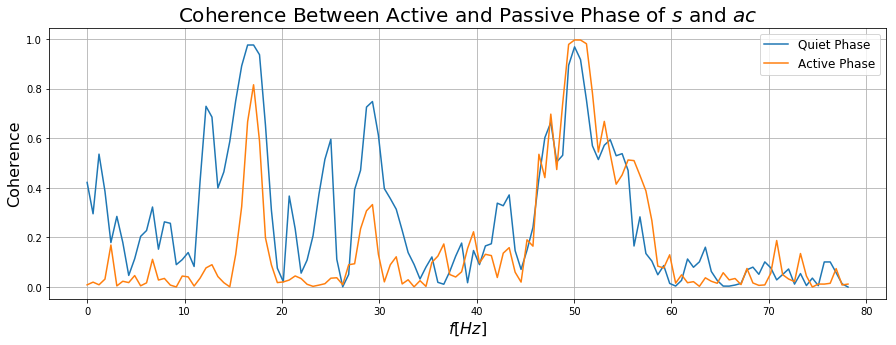

In [88]:
plt.figure(figsize=(15,5))
plt.plot(ff_qui, cohere_qui, label='Quiet Phase')
plt.plot(ff_act, cohere_act, label='Active Phase')
plt.grid()
plt.legend(fontsize=12)
plt.ylabel(r'Coherence', fontsize=16)
plt.xlabel(r'$f [Hz]$', fontsize=16)
plt.title('Coherence Between Active and Passive Phase of $s$ and $ac$', fontsize=20)
plt.show()

If $C_{xy}$ is less than one but greater than zero it is an indication that either: noise is entering the measurements, that the assumed function relating $s(t)$ and $ac(t)$ is not linear, or that $s(t)$ is producing output due to input $ac(t)$ as well as other inputs.